# Hierarchical clustering

In this lab we will implement hierarchical agglomerative clustering algorithms and apply them to **[Mall Customers dataset](https://www.kaggle.com/sivaram1987/mall-customers)** from Kaggle in order to find the best clustering of the customers.

The dataset contains records about 200 customers. For each customer there are 5 features:
1. CustomerID
2. Gender
3. Age
4. Annual Income
5. Spending Score

In our analysis we will use only the latter two features, i.e. **Annual Income** and **Spending Score**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

We first prepare the dataset by reading from the file for every customer only the two features of interest.

In [2]:
def load_data(fname):
    features = []
    
    with open(fname) as F:
        next(F) # skip the first line with feature names
        for line in F:
            p = line.strip().split(',')
            features.append(np.array(p[3:5], int))
    return np.array(features)

In [3]:
dataset = load_data("mall.csv")

#print(dataset)

# Exercise 1

1. Implement single-linkage agglomerative clustering
2. Implement complete-linkage agglomerative clustering
3. Implement group-average linkage agglomerative clustering

In each of the algorithms use the Euclidean distance as a dissimilarity measure between objects.

In [4]:
def Euclidean(x, y):
    # Compute the Euclidean distance between x and y
    return np.linalg.norm(x - y) 

In [5]:
# Computes distances matrix for a given dataset and a disntace function 
def distanceMatrix(dataset, dist=Euclidean):
    # Compute the number of objects in the dataset
    N = len(dataset)
    
    # Distance matrix
    distMatrix = np.zeros((N, N))
    # Compute pairwise distances between the objects
    for i in range(N):
        for j in range (N):
            # Distance is symmetric, so compute the distances between i and j only once
            if i < j:
                distMatrix[i][j] = dist(dataset[i], dataset[j])
                distMatrix[j][i] = distMatrix[i][j]
            
    return distMatrix

In [6]:
# Computes single-linkage distance between two clusters
def singleLinkageDistance(distMatrix, cluster_i, cluster_j):    
    # single-linkage clustering
    return np.min(distMatrix[cluster_i][:,cluster_j])

In [7]:
# Computes complete-linkage distance between two clusters
def completeLinkageDistance(distMatrix, cluster_i, cluster_j):    
    # complete-linkage clustering
    return np.max(distMatrix[cluster_i][:,cluster_j])

In [8]:
# Computes group-average linkage distance between two clusters
def groupAverageLinkageDistance(distMatrix, cluster_i, cluster_j):    
    # group-average linkage clustering
    return np.sum(distMatrix[cluster_i][:,cluster_j])/(len(cluster_i)*len(cluster_j))

In [9]:
# Find a pair of clusters that are closest to each other with respect to a given cluster distance
def closestClusters(dataset, clusters, distMatrix, clusterDistance=singleLinkageDistance):
    # distance between the closest clusters
    minClusterDist = math.inf
    # indices of the closest clusters
    a = -1
    b = -1
    
    # Compute pairwise distances between the clusters
    for (i, cluster_i) in enumerate(clusters):
        for (j, cluster_j) in enumerate(clusters):
            if cluster_j > cluster_i:
                clusterDist = clusterDistance(distMatrix, cluster_i, cluster_j) 
                if clusterDist < minClusterDist:
                    # Found a closer pair of clusters: store the information about this pair of clusters
                    minClusterDist = clusterDist
                    a = i
                    b = j
    return (a,b)

In [10]:
# Computes hierarchy of clusterings for the given dataset with the given distance matrix 
# using clusterDistance as a distance between clusters 
def hcluser(dataset, distMatrix, clusterDistance=singleLinkageDistance):   
    # Compute the number of objects in the dataset
    N = len(dataset)
    
    # Create initial clustering consisting of singletons
    clusters = [[i] for i in range(N)]
    
    # Store hierarchy of clusterings in a dictionary
    # Key is the number of clusters, Value is the corresponding clustering
    hierarchyOfClusterings = {}
    hierarchyOfClusterings[N] = clusters
    
    # Compute clustering for each number of clusters from N-1 to 1 using single-linkage clustering rule
    for numClusters in range(N-1, 0, -1):
        # Find a pair of closest clusters
        (a,b) = closestClusters(dataset, clusters, distMatrix, clusterDistance)
        # Create a new cluster by merging the two clusters
        mergedCluster = clusters[a] + clusters[b]     
        # remove from the list the two clusters
        clusters = [clustering for (index, clustering) in enumerate(clusters) if index not in [a,b]]
        # and add to the list the new cluster
        clusters.append(mergedCluster)
        
        # Add new clustering to the hierarchy of clusterings
        hierarchyOfClusterings[numClusters] = clusters
    
    return hierarchyOfClusterings
    

# Exercise 2

1. Cluster **Mall Customers** dataset using the implemented single-linkage agglomerative clustering

In [11]:
# Compute distance matrix
distMatrix = distanceMatrix(dataset)

# Compute single-linkage clustering
singleLinkageHierarchyOfClusterings = hcluser(dataset, distMatrix, clusterDistance=singleLinkageDistance)

2. Cluster **Mall Customers** dataset using the implemented complete-linkage agglomerative clustering

In [12]:
# Compute complete-linkage clustering
completeLinkageHierarchyOfClusterings = hcluser(dataset, distMatrix, clusterDistance=completeLinkageDistance)

3. Cluster **Mall Customers** dataset using the implemented group-average linkage agglomerative clustering

In [13]:
# Compute group-average linkage clustering
groupAverageLinkageHierarchyOfClusterings = hcluser(dataset, distMatrix, clusterDistance=groupAverageLinkageDistance)

# Exercise 3

Implement Silhouette coefficient computation for a clustering

In [14]:
# Computes Silhouette Coefficient for every object in the dataset with respect to the given clustering and distance matrix
def silhouetteCoefficient(dataset, clusters, distMatrix):
    # Compute the number of objects in the dataset
    N = len(dataset)
    
    silhouette = [0 for i in range(N)]
    a = [0 for i in range(N)]
    b = [math.inf for i in range(N)]
    
    for (i, obj) in enumerate(dataset):
        for (cluster_id, cluster) in enumerate(clusters):
            clusterSize = len(cluster)
            if i in cluster:
                # compute a(obj)
                if clusterSize > 1:
                    a[i] = np.sum(distMatrix[i][cluster])/(clusterSize-1)
                else:
                    a[i] = 0
            else:
                # compute b(obj)
                tempb = np.sum(distMatrix[i][cluster])/clusterSize
                if tempb < b[i]: 
                    b[i] = tempb
                
    for i in range(N):
        silhouette[i] = 0 if a[i] == 0 else (b[i]-a[i])/np.max([a[i], b[i]])
    
    return silhouette

In [15]:
# Computes Silhouette Coefficient for the dataset with respect to the given clustering and distance matrix
def silhouette(dataset, clusters, distMatrix):
    return np.mean(silhouetteCoefficient(dataset, clusters, distMatrix))

# Exercise 4

1. For each of the hierarchy of clusterings computed in Exercise 2: 
    - extract clusterings with the number of clusters k=2,3,4,...,20
    - for each of the extracted clusterings compute Silhouette coefficient and plot the values on a single plot

In [16]:
# Plot Silhouette coefficients for different clusterings
def plotSilhouette(dataset, hierarchyOfClusterings, distMatrix, maxNumClusters=20, title=""):
    clusteringSilhouette = {}
    
    for i in range(2,maxNumClusters+1):
        clusteringSilhouette[i] = silhouette(dataset, hierarchyOfClusterings[i], distMatrix)
    
    #print(title, "Silhouette coefficients for different clusterings\n", clusteringSilhouette)

    plt.bar(range(len(clusteringSilhouette)), list(clusteringSilhouette.values()), align='center')
    plt.xticks(range(len(clusteringSilhouette)), list(clusteringSilhouette.keys()))
    plt.title(title, fontsize=16)
    plt.xlabel('Number of clusters', fontsize=14)
    plt.ylabel('Silhouette coefficient', fontsize=14)
    plt.show()
    
    bestNumClusters = max(clusteringSilhouette, key=clusteringSilhouette.get)
    print("The best clustering is with %d clusters. The corresponding Silhouette coefficient is %.4f" % (bestNumClusters, clusteringSilhouette[bestNumClusters]))

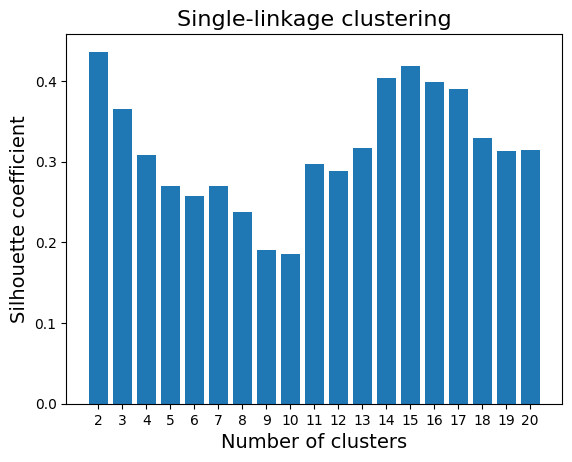

The best clustering is with 2 clusters. The corresponding Silhouette coefficient is 0.4364


In [17]:
plotSilhouette(dataset, singleLinkageHierarchyOfClusterings, distMatrix, maxNumClusters=20, title="Single-linkage clustering")

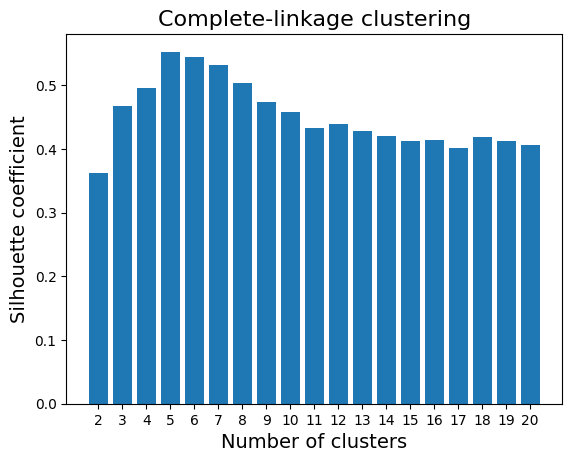

The best clustering is with 5 clusters. The corresponding Silhouette coefficient is 0.5525


In [18]:
plotSilhouette(dataset, completeLinkageHierarchyOfClusterings, distMatrix, maxNumClusters=20, title="Complete-linkage clustering")

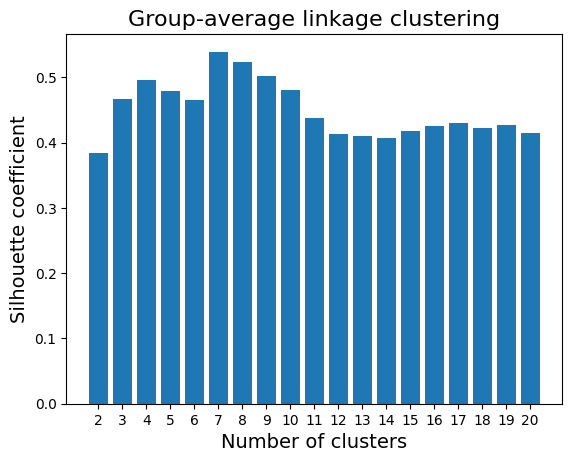

The best clustering is with 7 clusters. The corresponding Silhouette coefficient is 0.5394


In [19]:
plotSilhouette(dataset, groupAverageLinkageHierarchyOfClusterings, distMatrix, maxNumClusters=20, title="Group-average linkage clustering")

2. Which algorithm produced the best clustering and what is the number of clusters in this clustering?

The highest Silhouette coefficient clustering was produced by the complete-linkage clustering algorithm. The clustering contains 5 clusters.

# Exercise 5

Visualise the best clustering of the dataset from the previous exercise on a single plot by coloring different clusters by different colours.

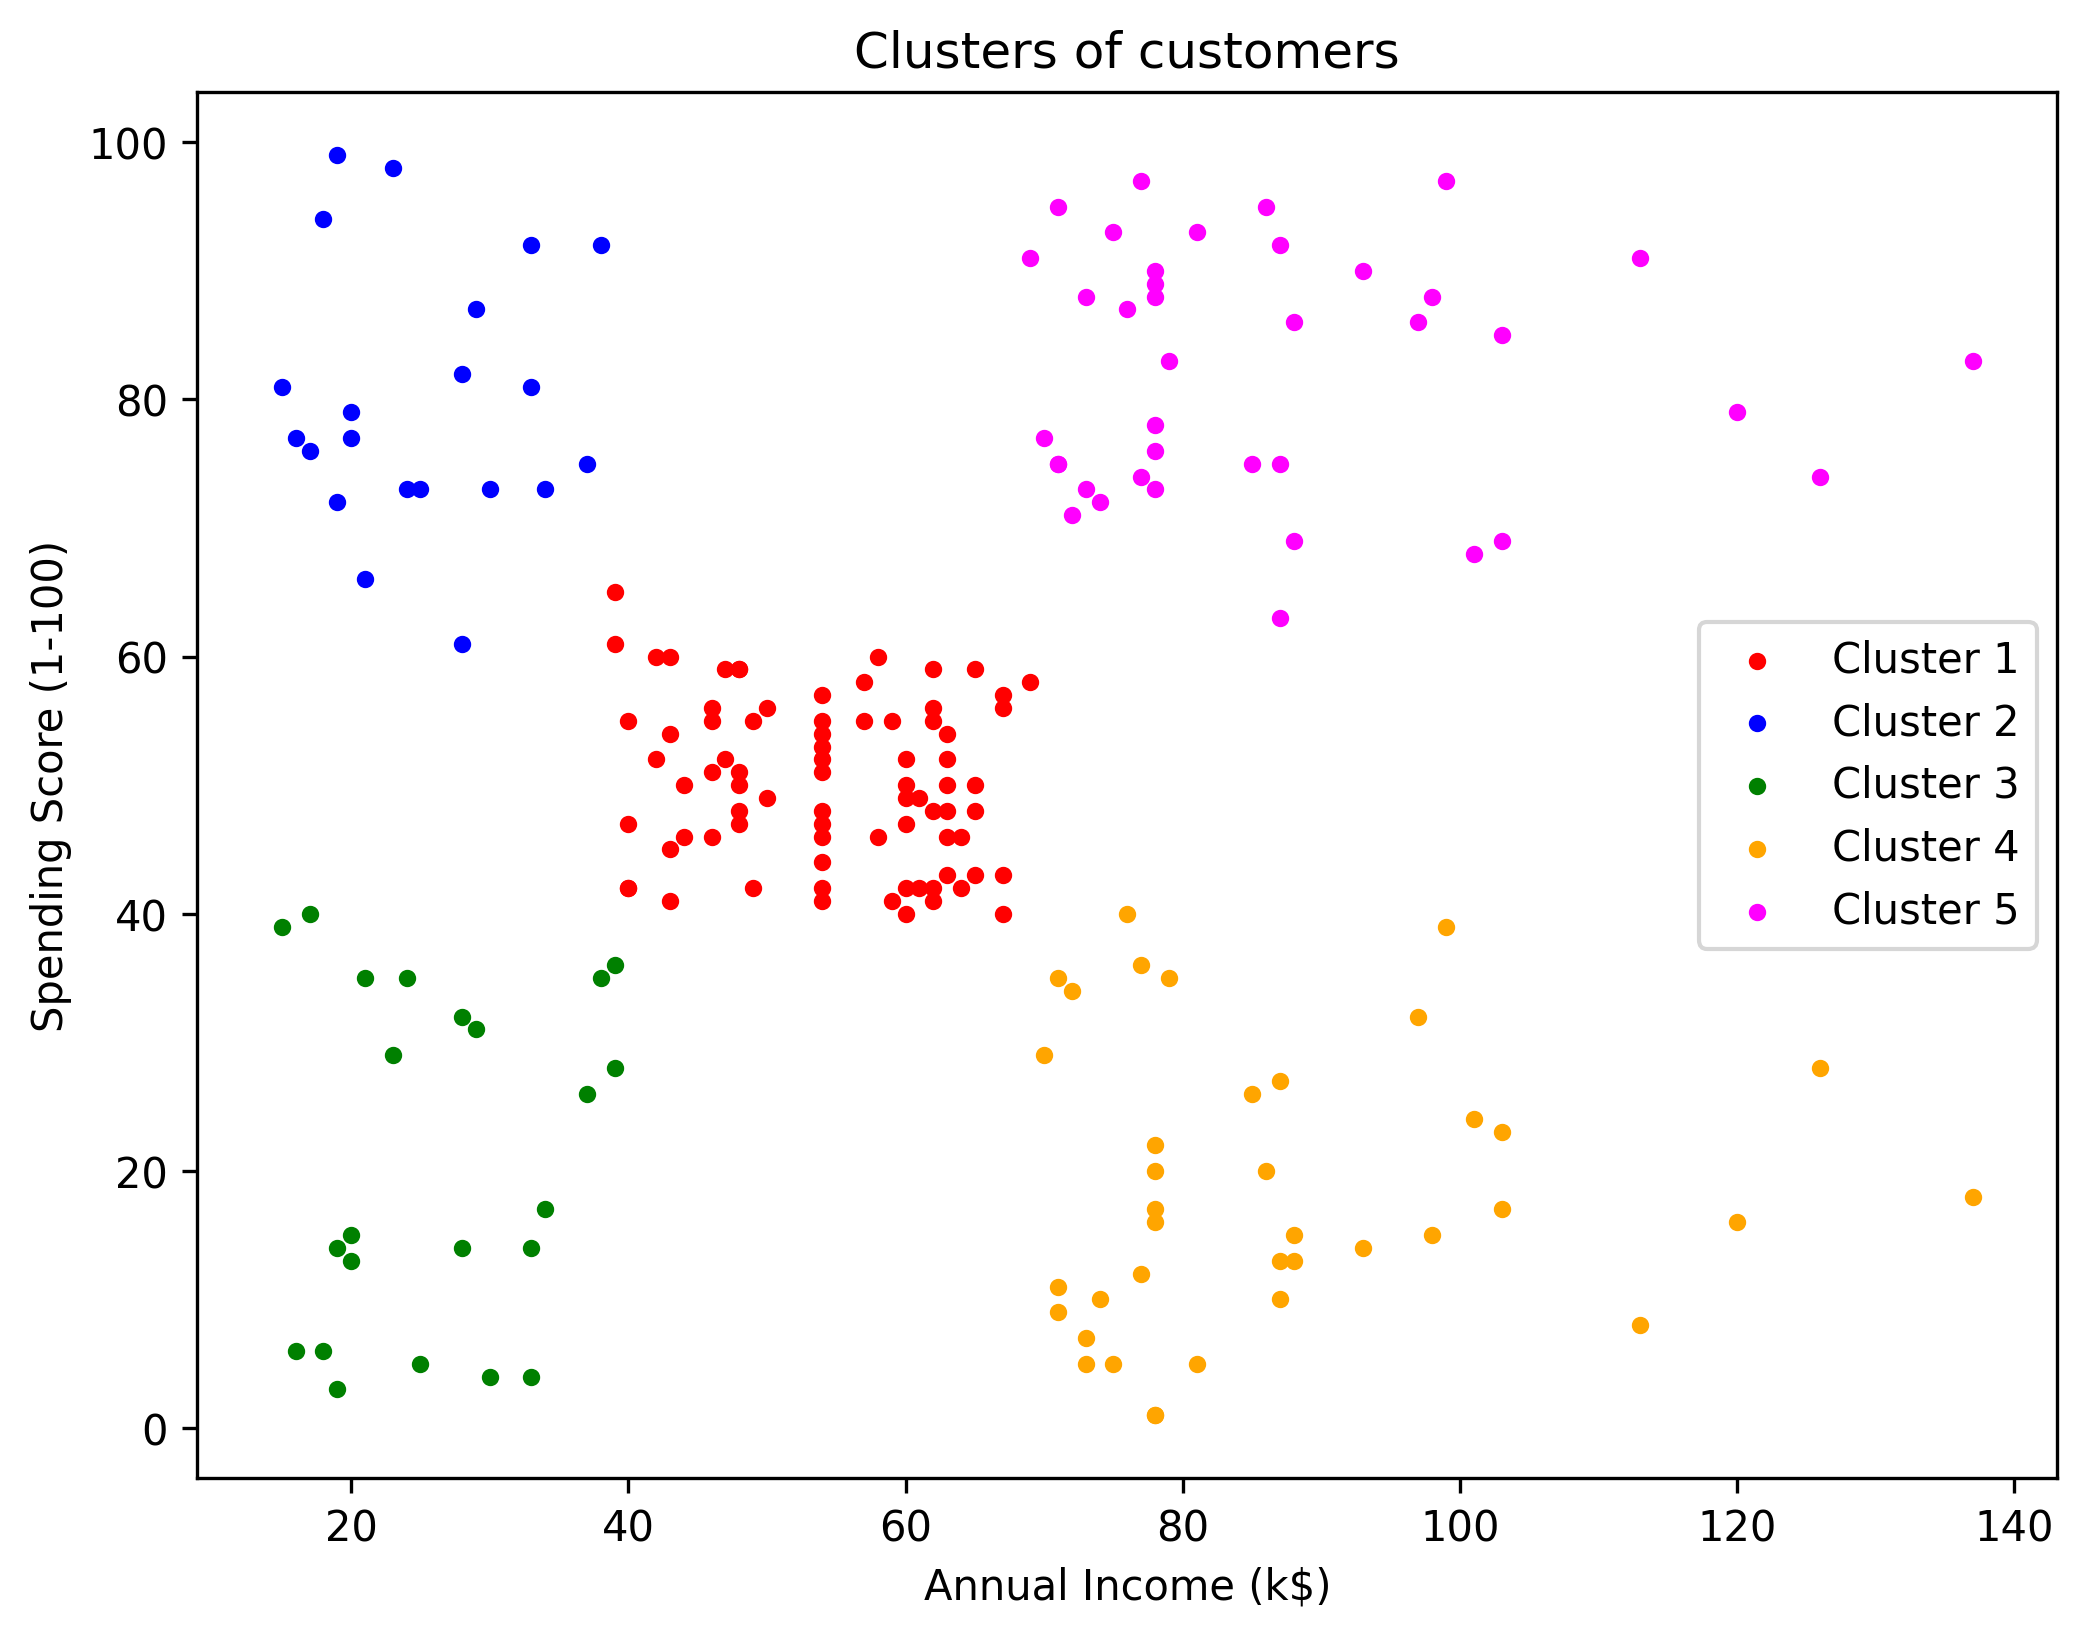

In [20]:
bestClustering = completeLinkageHierarchyOfClusterings[5]

cluster1 = bestClustering[0]
cluster2 = bestClustering[1]
cluster3 = bestClustering[2]
cluster4 = bestClustering[3]
cluster5 = bestClustering[4]

plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(dataset[cluster1][:,0], dataset[cluster1][:,1], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(dataset[cluster2][:,0], dataset[cluster2][:,1], s = 10, c = 'blue', label = 'Cluster 2')
plt.scatter(dataset[cluster3][:,0], dataset[cluster3][:,1], s = 10, c = 'green', label = 'Cluster 3')
plt.scatter(dataset[cluster4][:,0], dataset[cluster4][:,1], s = 10, c = 'orange', label = 'Cluster 4')
plt.scatter(dataset[cluster5][:,0], dataset[cluster5][:,1], s = 10, c = 'magenta', label = 'Cluster 5')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()